In [13]:
import os
import pandas as pd

# import all the training and testing data into a dataframe where 1 is positive, 0 is negative

def read_review_files(folder_path):
    df = pd.DataFrame({'Review': [], 'Category': []})
    folders = ['neg', 'pos']
    
    for f in folders:
        path  = os.path.join(folder_path, f)
        output = 1
        if f == 'neg': 
            output = 0
        for file in os.listdir(path):
            new_row = {'Review': open(f"{path}/{file}", 'r').read(), 'Category': output}
            df.loc[len(df)] = new_row
    return df

train_data_raw = read_review_files('./aclImdb/train')

In [14]:
train_data_raw['Category']

0        0
1        0
2        0
3        0
4        0
        ..
24995    1
24996    1
24997    1
24998    1
24999    1
Name: Category, Length: 25000, dtype: int64

In [15]:
def preprocess_input(df):
    new_df = df.copy()
    # remove all the special characters
    # df['Review'] = re.sub('[^A-Za-z\s]+', "", df['Review'])
    new_df['Review'] = new_df['Review'].str.replace('[^0-9A-Za-z\s]+', '', regex = True)
    # remove all the leading and tailing spaces
    new_df['Review'] = new_df['Review'].str.strip()
    # convert all the text into lower case
    new_df['Review'] = new_df['Review'].str.lower()
    
    return new_df

train_data = preprocess_input(train_data_raw)

In [16]:
train_data.loc[8]['Review']

'i chose to see this movie because it got a good score here on imdb but a lot of people either have really poor taste or someones been fixing the scorebr br either way it was a real disappointment the movie is exactly as stupid and far fetched as the title would suggest there really is no reason to give a summary of the plot  but here goes it felt like someone had been thinking wouldnt it be cool to make a movie where there were snakes on a plane and then the snakes for some reason would go crazy and start biting and stuff and thats about it the plot is thin and unoriginal the snakes are bad cgi but it makes sense to cut corners on a movie that no one in their right mind will recommend to anyone the acting is poor and all people are unbelievable stereo typesbr br to sum it up its one of the worst movies ive ever seen  stay away'

In [17]:
import tensorflow as tf
from tensorflow import keras

tokenizer = keras.preprocessing.text.Tokenizer()
# update internal vocabulary based on a list of texts
tokenizer.fit_on_texts(train_data['Review'])
# transform training and testing input data into sequence of integers
input_train = tokenizer.texts_to_sequences(train_data['Review'])

In [18]:
from sklearn.model_selection import train_test_split

input_train = keras.preprocessing.sequence.pad_sequences(input_train)
input_train, input_validate, output_train, output_validate = train_test_split(input_train, train_data['Category'], test_size = 0.25, random_state = 23)

In [19]:
input_train

array([[    0,     0,     0, ...,    30,     3, 86761],
       [    0,     0,     0, ...,   335,  1110,   389],
       [    0,     0,     0, ...,    48,     5,   102],
       ...,
       [    0,     0,     0, ...,    25,    74,  2888],
       [    0,     0,     0, ...,    30,     1,   128],
       [    0,     0,     0, ...,    21,     5,  1467]], dtype=int32)

In [20]:
# construct the CNN model
# the shape of the input is the size of the vocabulary base, aka. tokenizer
word_count = len(tokenizer.word_index) + 1

network = keras.Sequential()
network.add(keras.layers.Embedding(word_count, 16))
network.add(keras.layers.Dropout(0.15))
network.add(keras.layers.SimpleRNN(units = 16, activation = "relu"))
network.add(keras.layers.Dropout(0.15))
network.add(keras.layers.Dense(32, activation = 'relu'))
network.add(keras.layers.Dropout(0.15))
network.add(keras.layers.Dense(1, activation = 'sigmoid'))

network.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          1940496   
                                                                 
 dropout_3 (Dropout)         (None, None, 16)          0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 16)                528       
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                544       
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [21]:
network.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


training_progress = network.fit(input_train, output_train, epochs = 10, 
                    validation_data = (input_validate, output_validate),
                    verbose = 1,
                    batch_size = 512)

Epoch 1/10
37/37 [==============================] - 24s 617ms/step - loss: 0.6922 - accuracy: 0.5229 - val_loss: 0.6906 - val_accuracy: 0.5613
Epoch 2/10
37/37 [==============================] - 21s 574ms/step - loss: 0.6809 - accuracy: 0.6125 - val_loss: 0.6735 - val_accuracy: 0.6070
Epoch 3/10
37/37 [==============================] - 21s 572ms/step - loss: 0.5926 - accuracy: 0.7251 - val_loss: 0.4895 - val_accuracy: 0.7781
Epoch 4/10
37/37 [==============================] - 21s 572ms/step - loss: 0.3718 - accuracy: 0.8490 - val_loss: 0.3721 - val_accuracy: 0.8400
Epoch 5/10
37/37 [==============================] - 21s 572ms/step - loss: 0.2151 - accuracy: 0.9238 - val_loss: 0.3414 - val_accuracy: 0.8614
Epoch 6/10
37/37 [==============================] - 21s 574ms/step - loss: 0.1492 - accuracy: 0.9485 - val_loss: 0.3880 - val_accuracy: 0.8627
Epoch 7/10
37/37 [==============================] - 21s 572ms/step - loss: 0.0928 - accuracy: 0.9709 - val_loss: 0.4158 - val_accuracy: 0.8582

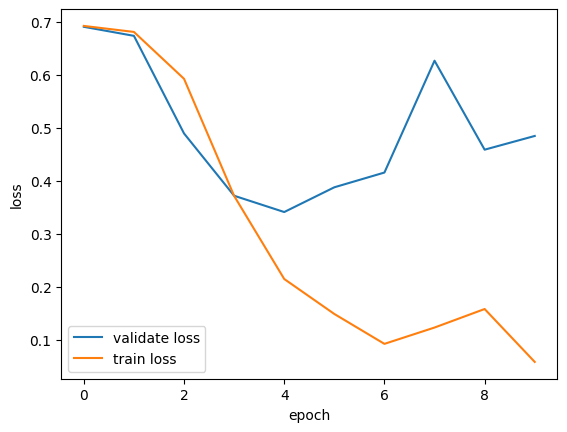

In [22]:
import matplotlib.pyplot as plt

# plot loss vs. epoch
plt.plot(training_progress.history['val_loss'],label="validate loss")
plt.plot(training_progress.history['loss'],label="train loss")
plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend()
plt.show()

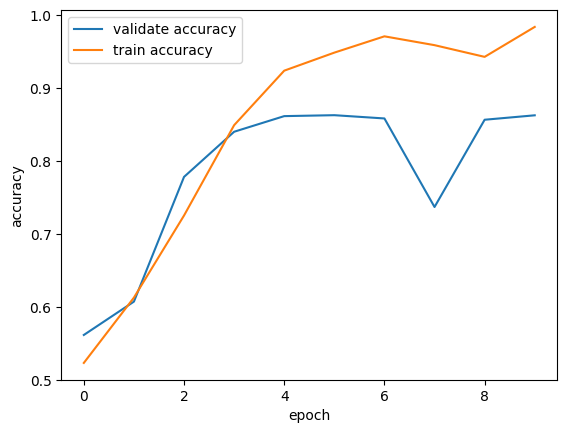

In [23]:
import matplotlib.pyplot as plt

# plot accuracy vs. epoch
plt.plot(training_progress.history['val_accuracy'],label="validate accuracy")
plt.plot(training_progress.history['accuracy'],label="train accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.legend()
plt.show()

In [24]:
network.save("./models/20591615_NLP_model.h5")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
